# Optimisation pour le réseau CIGRE adapté

## First Network

## Author: Ana Luiza Haas Bezerra ; Co-Author: Fernando Enrique Barbosa Santiago

In [19]:
# Uploading the network from CIGRE

import pandapower as pp
import pandapower.networks as pn


global net_cigre
global s
global Vn


net_cigre = pn.create_cigre_network_mv(with_der="pv_wind") # Network with PV and wing DER

'''
This pandapower network includes the following parameter tables:
  - switch (8 elements)
  - load (18 elements)
  - ext_grid (1 elements)
  - sgen (9 elements)
  - line (15 elements)
  - trafo (2 elements)
  - bus (15 elements)
  - bus_geodata (15 elements)
'''


'\nThis pandapower network includes the following parameter tables:\n  - switch (8 elements)\n  - load (18 elements)\n  - ext_grid (1 elements)\n  - sgen (9 elements)\n  - line (15 elements)\n  - trafo (2 elements)\n  - bus (15 elements)\n  - bus_geodata (15 elements)\n'

# Desestabilisation du réseau

Objectif : Avoir des sur tensions au niveau des GED

Premier pas : Augmenter le puissance dans les noeuds 1 et 12 (les plus proches de la source)

Deuxième pas : Changer les puissances des generateurs pour desestabiliser le réseau pour avoir des surtensions

In [20]:
# Changer la puissance d'un générateur

net_cigre.sgen.at[8,'p_mw'] = 8
net_cigre.sgen.at[8,'sn_mva'] = 8
pp.create_sgen(net_cigre,bus=11,p_mw=6,q_mvar=0,sn_mva=6,name='WKA 11',type='WP')

# On prend le générateur 8 parce qu'il possède le plus de puissance déjà et des producteurs éoliens
# fournissent des puissances en général plus élévées

pp.create_sgen(net_cigre,bus=1,p_mw=10,q_mvar=0,sn_mva=10,name='WKA 1',type='WP')
pp.create_sgen(net_cigre,bus=12,p_mw=10,q_mvar=0,sn_mva=10,name='WKA 12',type='WP')

pp.runpp(net_cigre) # run the network

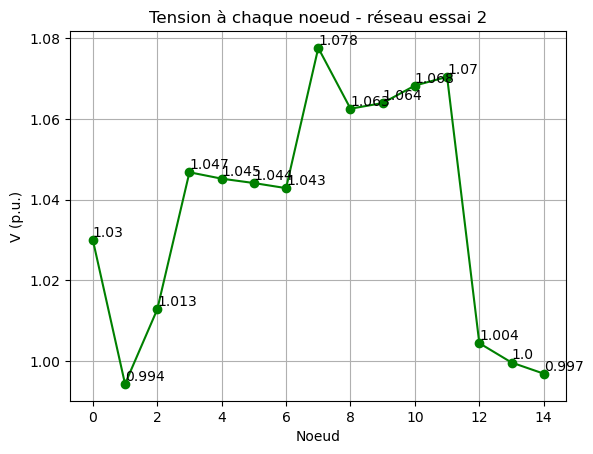

In [22]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np

# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud - réseau essai 2')
plt.plot(xaxis, yaxis, '-go')
plt.show()

In [23]:
from pandapower.plotting import simple_plot, pf_res_plotly
pf_res_plotly(net_cigre)

## Optimisation mono-objective

Dans cette partie, il est developpé le problème d'optimisation avec un nombre fixé de selfs (s). Le problème est définit de la manière suivante :

##### Variables : 

$q \in [ 0,\inf ]^N$

$q = (q_i)_{1 \leq i \leq N}$, $q_i$ [MVAr] : puissance reactive de la self au noeud i, active si $x_i = 1$

##### Paramètres :

N [-] : quantité de noeuds du réseau

s [-] : quantité de selfs à installer

$V_n$ [kV] : tension nominal du réseau (20 kV pour un réseau HTA)

##### Formulation du problème

La formulation du problème pour la résolution avec l'algorithme deterministe SLSQP utilise des variables réeles seulement afin de rendre possible l'estimation d'un Jacobian. La constrainte d'égalité pour les selfs n'est pas traitée directement comme contrainte dans le code d'optimisation mais elle est présente dans le calcul des fonctions objectifs/contraintes, ce qui permet d'améliorer le surface d'optimisation. Les variables d'état $q_{act,i}$ sont les puissances installées dans les selfs choisies. Le problème d'optimisation est décrit ci-dessous :


$$
\begin{aligned}
\min_{q} \quad & \sum_{i=1}^{N}{q_{i}}  \quad & \textrm{s.t.} \quad & V_{i} \leq V_{max}\\
\quad & \quad & \quad & V_{i} \geq V_{min}    \\
\quad & \quad & \quad & q_{act,i} \geq 0,2    \\
\quad & \quad & \quad & \sum_{i=1}^{N}{\mathbb{1}_{] 0,\inf ]}(q_i)} = s    \\
\end{aligned}
$$

In [6]:
#Makes the optimisation space better

def shigher(x,s):
    aux = np.array([0.0*i for i in range(len(x))])
    x = x.copy()
    j = 0
    while j<s:
        idx = x.argmax()
        aux[idx] = x[idx]
        x[idx] = 0
        j+=1
    return aux


In [7]:
def fct_model_reseau(variables):
    
    ##Variables du modèle :
    
    q_self = variables # q_selfi[MVAr]: puissance reactive installée comme self à chaque noeud i
    q_self = shigher(q_self,s)

    ##Paramètres du modèle :
    
    # s[-]: nb de selfs à installer
    # Vn[kV]: tension nominal du réseau
    N = len(q_self) #N[-]: nb de noeuds du réseau (exclut le noeud source)
    
    ##Éliminant des selfs inclus par la dernière itération de l'algo
    i=len(net_cigre.shunt)-1
    if len(net_cigre.shunt) > 0:
        while i>=0:
            net_cigre.shunt.drop(i, inplace=True)
            i-=1

    ##Creer des shunts
    for index in range(N):
        if q_self[index] != 0:
            pp.create_shunt(net=net_cigre,bus = index+1,q_mvar = q_self[index],p_mw = 0) #On utilise index +1 pour éviter le noeud source (bus 0)

    ##Calcul avec pandapower des tension dans les noeuds
    pp.runpp(net_cigre)
    V_noeud_aux = (net_cigre.res_bus['vm_pu'].values.tolist())
    V_noeud = [Vn*i for i in V_noeud_aux[1::]] #On prend toutes les tensions au réseau sauf la tension au noeud source (bus 0)


    ##Calcul des outputs
    outputs = np.array(V_noeud) # 0.95Vn<V<1.05Vn : contrainte de tension avec limite supérieur et inférieur

    return outputs



In [8]:
net_cigre.shunt

Empty DataFrame
Columns: [bus, name, q_mvar, p_mw, vn_kv, step, max_step, in_service]
Index: []

### 1) Cas avec s = 1

In [95]:
#Optimisations mono-objectif avec SLSQP with multi-start
import scipy.optimize
import random
from scipy.optimize import NonlinearConstraint, minimize, Bounds
import numpy as np
import math

#Paramètres du modèle :

Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds = Bounds([0]*N, [math.inf]*N)
bounds = np.array([[0,math.inf]]*N)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)


def q_installe(x):
    x = shigher(x,s)
    q_active_cons = [0]*s
    i=0
    for qi in x:
        if qi>1e-9 and i<len(q_active_cons):
            q_active_cons[i]=(qi)
            i+=1
    return q_active_cons

 

ineq_cons_tensioninf = {'type': 'ineq', 'fun' : lambda x: fct_model_reseau(x)-np.array(lb_ineq_V)} #contraintes sur les tensions
ineq_cons_tensionsup = {'type': 'ineq', 'fun' : lambda x: -fct_model_reseau(x)+np.array(ub_ineq_V)} #contraintes sur les tensions
ineq_cons_q = {'type': 'ineq', 'fun' : lambda x: np.array(q_installe(x))-np.array([0.2]*len(q_installe(x)))} #contraintes sur la puissance reactive installé


#On a encore besoin de créer la fonction de cout 
def f(x):
    x = shigher(x,s)
    return sum(x)


#Point initial avec multi-start

s = 1 # s[-]: nb de selfs à installer
N_iter = 100 #Number of iteration
best_f = math.inf #Keeps the best cost function between all iterations
best_q = np.array([0*i for i in range(14)],dtype=np.float32) #Keeps the optimum that gives best_f

net_bkp = net_cigre
counter = 0
for n in range(N_iter):
    net_cigre = net_bkp
    x0 = np.array([0*i for i in range(14)],dtype=np.float32) #on part de notre réseau initiale cigre avec nb de selfs fixe à 1, 14 noeuds et tension nominale de 20kV
    for i in range(N):
        random_nb = random.uniform(0,1)
        while random_nb < 0.2 and random_nb != 0:
            random_nb = random.uniform(0,1)
        x0[i]=random_nb
    
    #Solver
    try:
        res = minimize(f, x0, method='SLSQP', constraints=[ineq_cons_tensioninf, ineq_cons_tensionsup, ineq_cons_q], options={'ftol': 1e-9, 'disp': False},bounds=bounds)
        success_flag = res.success
    except:
        success_flag = False
        counter += 1
    if success_flag == True:
        if res.fun < best_f:
            best_f = res.fun
            best_q = shigher(res.x,s)
    print("Iteration:",n)
    print(best_f)
    print(best_q)
            
print(best_f)
print(best_q)

Iteration: 0
1.4190135485101878
[0.         0.         0.         0.         0.         1.41901355
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 1
1.1905150454435873
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.19051505 0.
 0.         0.        ]
Iteration: 2
1.1905150454435873
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.19051505 0.
 0.         0.        ]
Iteration: 3
1.1905150454435873
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.19051505 0.
 0.         0.        ]
Iteration: 4
1.1905150454435873
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.19051505 0.
 0.         0.        ]
Iteration: 5
1.1905150454435873
[0.         0.         0.         0.         0.         0.
 0.         0.         0.      

In [96]:
fct_model_reseau(best_q)
net_cigre.shunt

bus  name   q_mvar  p_mw  vn_kv  step  max_step  in_service
0    7  None  1.03404   0.0   20.0     1         1        True

1.0340398505501207
[0.         0.         0.         0.         0.         0.
 1.03403985 0.         0.         0.         0.         0.
 0.         0.        ]


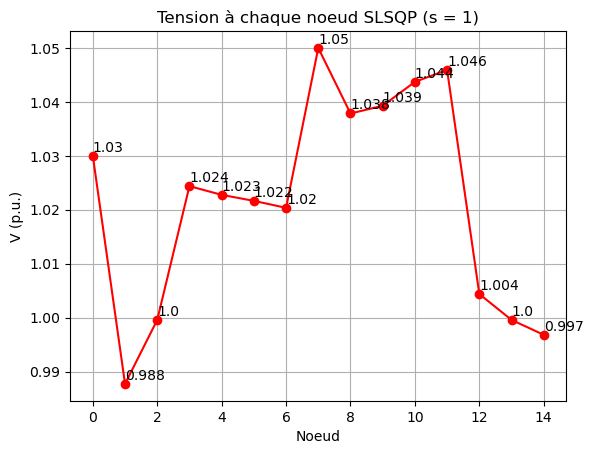

In [98]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np

print(best_f)
print(best_q)
fct_model_reseau(best_q)

# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud SLSQP (s = 1)')
plt.plot(xaxis, yaxis, '-ro')
plt.show()

### 2) Cas avec s = 2

In [106]:
#Optimisations mono-objectif avec SLSQP with multi-start
import scipy.optimize
import random
from scipy.optimize import NonlinearConstraint, minimize, Bounds
import numpy as np
import math

#Paramètres du modèle :

Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau
s = 2 # s[-]: nb de selfs à installer

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds = Bounds([0]*N, [math.inf]*N)
bounds = np.array([[0,math.inf]]*N)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)


def q_installe(x):
    x = shigher(x,s)
    q_active_cons = [0]*s
    i=0
    for qi in x:
        if qi>1e-9 and i<len(q_active_cons):
            q_active_cons[i]=(qi)
            i+=1
    return q_active_cons

 

ineq_cons_tensioninf = {'type': 'ineq', 'fun' : lambda x: fct_model_reseau(x)-np.array(lb_ineq_V)} #contraintes sur les tensions
ineq_cons_tensionsup = {'type': 'ineq', 'fun' : lambda x: -fct_model_reseau(x)+np.array(ub_ineq_V)} #contraintes sur les tensions
ineq_cons_q = {'type': 'ineq', 'fun' : lambda x: np.array(q_installe(x))-np.array([0.2]*len(q_installe(x)))} #contraintes sur la puissance reactive installé


#On a encore besoin de créer la fonction de cout 
def f(x):
    x = shigher(x,s)
    return sum(x)


#Point initial avec multi-start

N_iter = 50 #Number of iteration
best_f2 = math.inf #Keeps the best cost function between all iterations
best_q2 = np.array([0*i for i in range(14)],dtype=np.float32) #Keeps the optimum that gives best_f

net_bkp = net_cigre
counter = 0
for n in range(N_iter):
    net_cigre = net_bkp
    x0 = np.array([0*i for i in range(14)],dtype=np.float32) #on part de notre réseau initiale cigre avec nb de selfs fixe à 1, 14 noeuds et tension nominale de 20kV
    for i in range(N):
        random_nb = random.random()
        while random_nb < 0.2 and random_nb != 0:
            random_nb = random.random()
        x0[i]=random_nb
    
    #Solver
    try:
        res2 = minimize(f, x0, method='SLSQP', constraints=[ineq_cons_tensioninf, ineq_cons_tensionsup, ineq_cons_q], options={'ftol': 1e-9, 'disp': False},bounds=bounds)
        success_flag2 = res2.success
    except:
        success_flag2 = False
        counter += 1
    if success_flag2 == True:
        if res2.fun < best_f2:
            best_f2 = res2.fun
            best_q2 = shigher(res2.x,s)
    print("Iteration:",n)
    print(best_f2)
    print(best_q2)
            
print(best_f2)
print(best_q2)

Iteration: 0
inf
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration: 1
1.2394844954590163
[0.         0.         0.         0.         0.5810699  0.
 0.65841459 0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 2
1.2394844954590163
[0.         0.         0.         0.         0.5810699  0.
 0.65841459 0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 3
1.2394844954590163
[0.         0.         0.         0.         0.5810699  0.
 0.65841459 0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 4
1.2394844954590163
[0.         0.         0.         0.         0.5810699  0.
 0.65841459 0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 5
1.2394844954590163
[0.         0.         0.         0.         0.5810699  0.
 0.65841459 0.         0.         0.         0.         0.
 0.         0.        ]
Iteration: 6
1.2394844954590163
[0.         0.         0.         0. 

1.1894738262497249
[0.         0.         0.         0.         0.         0.
 0.58928877 0.         0.60018506 0.         0.         0.
 0.         0.        ]


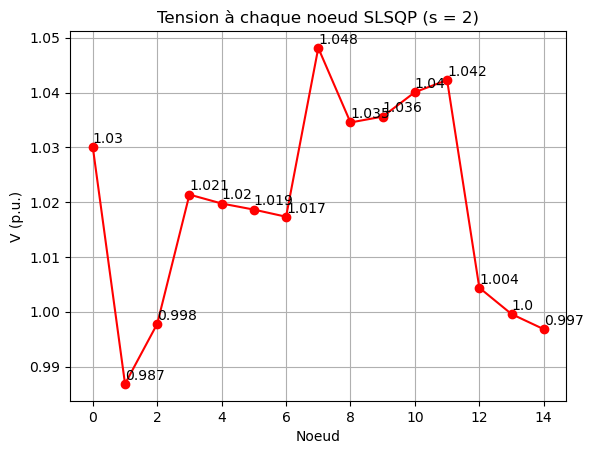

In [107]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np

print(best_f2)
print(best_q2)
fct_model_reseau(best_q2)

# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud SLSQP (s = 2)')
plt.plot(xaxis, yaxis, '-ro')
plt.show()

### 3) Cas avec s = 3

In [108]:
#Optimisations mono-objectif avec SLSQP with multi-start
import scipy.optimize
import random
from scipy.optimize import NonlinearConstraint, minimize, Bounds
import numpy as np
import math

#Paramètres du modèle :

Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds = Bounds([0]*N, [math.inf]*N)
bounds = np.array([[0,math.inf]]*N)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)


def q_installe(x):
    x = shigher(x,s)
    q_active_cons = [0]*s
    i=0
    for qi in x:
        if qi>1e-9 and i<len(q_active_cons):
            q_active_cons[i]=(qi)
            i+=1
    return q_active_cons

 

ineq_cons_tensioninf = {'type': 'ineq', 'fun' : lambda x: fct_model_reseau(x)-np.array(lb_ineq_V)} #contraintes sur les tensions
ineq_cons_tensionsup = {'type': 'ineq', 'fun' : lambda x: -fct_model_reseau(x)+np.array(ub_ineq_V)} #contraintes sur les tensions
ineq_cons_q = {'type': 'ineq', 'fun' : lambda x: np.array(q_installe(x))-np.array([0.2]*len(q_installe(x)))} #contraintes sur la puissance reactive installé


#On a encore besoin de créer la fonction de cout 
def f(x):
    x = shigher(x,s)
    return sum(x)


#Point initial avec multi-start

s = 3 # s[-]: nb de selfs à installer
N_iter = 50 #Number of iteration
best_f3 = math.inf #Keeps the best cost function between all iterations
best_q3 = np.array([0*i for i in range(14)],dtype=np.float32) #Keeps the optimum that gives best_f

net_bkp = net_cigre
counter = 0
for n in range(N_iter):
    net_cigre = net_bkp
    x0 = np.array([0*i for i in range(14)],dtype=np.float32) #on part de notre réseau initiale cigre avec nb de selfs fixe à 1, 14 noeuds et tension nominale de 20kV
    for i in range(N):
        random_nb = random.random()
        while random_nb < 0.2 and random_nb != 0:
            random_nb = random.random()
        x0[i]=random_nb
    
    #Solver
    try:
        res3 = minimize(f, x0, method='SLSQP', constraints=[ineq_cons_tensioninf, ineq_cons_tensionsup, ineq_cons_q], options={'ftol': 1e-9, 'disp': False},bounds=bounds)
        success_flag3 = res3.success
    except:
        success_flag3 = False
        counter += 1
    if success_flag3 == True:
        if res3.fun < best_f3:
            best_f3 = res3.fun
            best_q3 = shigher(res3.x,s)
    print("Iteration:",n)
    print(best_f3)
    print(best_q3)
            
print(best_f3)
print(best_q3)

Iteration: 0
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.         0.52692188 0.
 0.         0.        ]
Iteration: 1
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.         0.52692188 0.
 0.         0.        ]
Iteration: 2
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.         0.52692188 0.
 0.         0.        ]
Iteration: 3
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.         0.52692188 0.
 0.         0.        ]
Iteration: 4
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.         0.52692188 0.
 0.         0.        ]
Iteration: 5
1.4793828502449577
[0.         0.50631013 0.         0.         0.         0.
 0.         0.44615084 0.         0.   

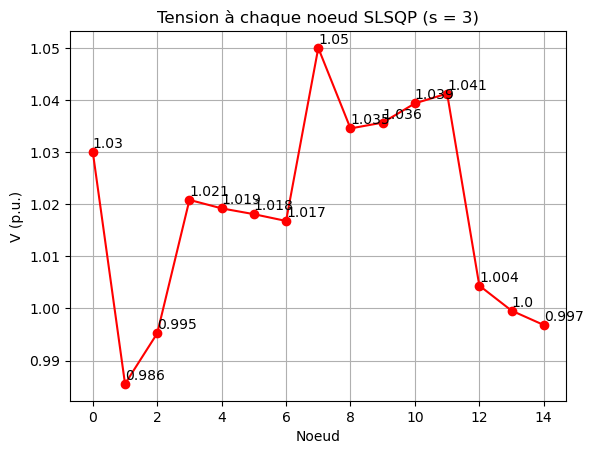

In [12]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np

print(best_f3)
print(best_q3)
fct_model_reseau(best_q3)

# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud SLSQP (s = 3)')
plt.plot(xaxis, yaxis, '-ro')
plt.show()

### 4) Cas avec s = 4

In [13]:
#Optimisations mono-objectif avec SLSQP with multi-start
import scipy.optimize
import random
from scipy.optimize import NonlinearConstraint, minimize, Bounds
import numpy as np
import math

#Paramètres du modèle :

Vn = 20 # Vn[kV]: tension nominal du réseau
N = 14 # N[-]: nb de noeuds du réseau

# Definisions les boundaries de la variables d'optimisation (qi peut être entre 0 et inf, si elle est active sa valeur minimale est 200 kVAr)
bounds = Bounds([0]*N, [math.inf]*N)
bounds = np.array([[0,math.inf]]*N)

#Definisons des contraintes d'inégalité et égalité

lb_ineq_V =[]
ub_ineq_V =[]
lb_ineq_q =[]
ub_ineq_q =[]
lb_eq_s = s
ub_eq_s = s
for i in range(N):
    lb_ineq_V.append(0.95*Vn)
    ub_ineq_V.append(1.05*Vn)
for i in range(s):
    ub_ineq_q.append(math.inf)
    lb_ineq_q.append(0.2)


def q_installe(x):
    x = shigher(x,s)
    q_active_cons = [0]*s
    i=0
    for qi in x:
        if qi>1e-9 and i<len(q_active_cons):
            q_active_cons[i]=(qi)
            i+=1
    return q_active_cons

 

ineq_cons_tensioninf = {'type': 'ineq', 'fun' : lambda x: fct_model_reseau(x)-np.array(lb_ineq_V)} #contraintes sur les tensions
ineq_cons_tensionsup = {'type': 'ineq', 'fun' : lambda x: -fct_model_reseau(x)+np.array(ub_ineq_V)} #contraintes sur les tensions
ineq_cons_q = {'type': 'ineq', 'fun' : lambda x: np.array(q_installe(x))-np.array([0.2]*len(q_installe(x)))} #contraintes sur la puissance reactive installé


#On a encore besoin de créer la fonction de cout 
def f(x):
    x = shigher(x,s)
    return sum(x)


#Point initial avec multi-start

s = 4 # s[-]: nb de selfs à installer
N_iter = 50 #Number of iteration
best_f4 = math.inf #Keeps the best cost function between all iterations
best_q4 = np.array([0*i for i in range(14)],dtype=np.float32) #Keeps the optimum that gives best_f

net_bkp = net_cigre
counter = 0
for n in range(N_iter):
    net_cigre = net_bkp
    x0 = np.array([0*i for i in range(14)],dtype=np.float32) #on part de notre réseau initiale cigre avec nb de selfs fixe à 1, 14 noeuds et tension nominale de 20kV
    for i in range(N):
        random_nb = random.uniform(0,2)
        while random_nb < 0.2 and random_nb != 0:
            random_nb = random.uniform(0,2)
        x0[i]=random_nb
    
    #Solver
    try:
        res4 = minimize(f, x0, method='SLSQP', constraints=[ineq_cons_tensioninf, ineq_cons_tensionsup, ineq_cons_q], options={'ftol': 1e-9, 'disp': False},bounds=bounds)
        success_flag4 = res4.success
    except:
        success_flag4 = False
        counter += 1
    if success_flag4 == True:
        if res4.fun < best_f4:
            best_f4 = res4.fun
            best_q4 = shigher(res4.x,s)
    print("Iteration:",n)
    print(best_f4)
    print(best_q4)
            
print(best_f4)
print(best_q4)

Iteration: 0
1.8547439013159936
[0.2       0.2       0.        1.2547439 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.2      ]
Iteration: 1
1.4266881685995911
[0.         0.         0.         0.         0.         0.2
 0.         0.         0.2        0.82668817 0.         0.
 0.         0.2       ]
Iteration: 2
1.4266881685995911
[0.         0.         0.         0.         0.         0.2
 0.         0.         0.2        0.82668817 0.         0.
 0.         0.2       ]
Iteration: 3
1.166902499258258
[0.        0.        0.2       0.2       0.        0.        0.5669025
 0.        0.2       0.        0.        0.        0.        0.       ]
Iteration: 4
1.166902499258258
[0.        0.        0.2       0.2       0.        0.        0.5669025
 0.        0.2       0.        0.        0.        0.        0.       ]
Iteration: 5
1.166902499258258
[0.        0.        0.2       0.2       0.        0.        0.5669025
 0.        0.2       0.        0

1.1385169643927466
[0.         0.         0.2        0.         0.         0.
 0.53851696 0.         0.         0.2        0.2        0.
 0.         0.        ]


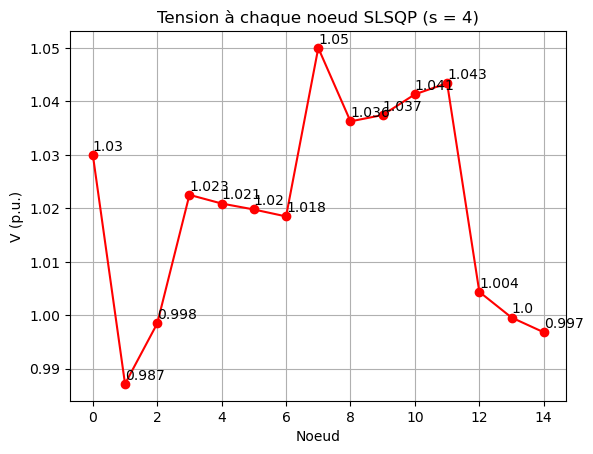

In [14]:
#Plotting the voltage with respect to the bus

import matplotlib.pyplot as plt
import numpy as np

print(best_f4)
print(best_q4)
fct_model_reseau(best_q4)

# X axis parameter:
xaxis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,10, 11, 12, 13, 14])

# Y axis parameter:
yaxis = net_cigre.res_bus['vm_pu']

# Labels
plt.ylabel('V (p.u.)')
plt.xlabel('Noeud')

for i in range(len(yaxis)):
    plt.annotate(str(round(yaxis[i], 3)), xy=(xaxis[i], yaxis[i]+0.0008))

plt.grid()
plt.title('Tension à chaque noeud SLSQP (s = 4)')
plt.plot(xaxis, yaxis, '-ro')
plt.show()